## GPcounts with zero-inflated negative binomial likelihood

Nuha BinTayyash, 2020

This notebook comapre GPcounts fit with zero-inflated negative binomial, negative binomial and Gaussian likelihoods on ScRNA-seq gene expression data for highly expressed genes in Islet $\alpha$ cell from [GSE8737 single cell RNA-seq ](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE87375) dataset.

In [1]:
import pandas as pd
import numpy as np
import gpflow 
from IPython.display import display

Load $\alpha$ dataset and pseudotime information

In [2]:
Y = pd.read_csv('normalized_alpha_counts.csv',index_col=[0])
X = pd.read_csv('alpha_time_points.csv',index_col=[0])

In [3]:
from GPcounts.GPcounts_Module import Fit_GPcounts

In [4]:
gene_name = ['ENSMUSG00000015879','ENSMUSG00000059173']

Probabilty of zeros in Fam184b and Pde1a genes

In [5]:
Y.loc[gene_name][Y.loc[gene_name] == 0].count(axis=1)/len(Y.columns)

ENSMUSG00000015879    0.859756
ENSMUSG00000059173    0.628049
dtype: float64

In [6]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

def plot(Sparse = False):
    plt.tick_params(labelsize='large', width=2)
    plt.rcParams.update({'font.size': 14})
    #plt.ylabel('Gene Expression', fontsize=16)
    #plt.xlabel('Times', fontsize=16)
    c = 'royalblue'
    
    if model_index == 3:
        c = 'green'
    
    plt.plot(xtest, mean,color= c, lw=2) 
    
    if likelihood == 'Gaussian':
        y = np.log(Y.loc[indexes[i]]+1)
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 1*np.sqrt(var[:,0]),
                            mean[:,0] + 1*np.sqrt(var[:,0]),color=c,alpha=0.2) # one standard deviation
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 2*np.sqrt(var[:,0]),
                            mean[:,0] + 2*np.sqrt(var[:,0]),color=c, alpha=0.1)# two standard deviation
    else:
        y = Y.loc[indexes[i]]
        lowess = sm.nonparametric.lowess    
        # one standard deviation 68%
        percentile_16 = lowess(np.percentile(var, 16, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_16 = [(i > 0) * i for i in percentile_16]
        percentile_84 = lowess(np.percentile(var, 84, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_84 = [(i > 0) * i for i in percentile_84]
        plt.fill_between(xtest[:,0],percentile_16,percentile_84,color=c,alpha=0.2)
        
        # two standard deviation 95%
        percentile_5 = lowess(np.percentile(var, 5, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_5 = [(i > 0) * i for i in percentile_5]
        percentile_95 = lowess(np.percentile(var,95, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_95 = [(i > 0) * i for i in percentile_95]
        plt.fill_between(xtest[:,0],percentile_5,percentile_95,color=c,alpha=0.1)
    
    if test == 'Two_samples_test' and model_index == 1:
        plt.scatter(X[0:int(X.shape[0]/2)],Y.loc[indexes[i]][0:int(X.shape[0]/2)], s=30, marker='o', color= 'royalblue',alpha=1.) #data    
        plt.scatter(X[int(X.shape[0]/2)::],Y.loc[indexes[i]][int(X.shape[0]/2)::], s=30, marker='o', color= 'green',alpha=1.) #data

    else: 
        plt.scatter(X,y,s=30,marker = 'o',color=c,alpha=1.)
    
    if Sparse:
        inducing_points = model.inducing_variable.Z.numpy() 
        # discard any inducing points outside X range
        inducing_points = inducing_points[inducing_points >= np.min(X.values)]
        inducing_points = inducing_points[inducing_points <= np.max(X.values)]
        
        plt.scatter(inducing_points,np.zeros(inducing_points.shape[0]),s=30,marker = '^',color='red',label='inducing points',alpha=1.) 
        plt.legend()
    if not(test == 'Two_samples_test' and model_index == 2):
        plt.show()
    

#### Fit GPcounts using full GP

100%|██████████| 2/2 [00:57<00:00, 28.82s/it]

The results for Zero_inflated_negative_binomial likelihood:


,Dynamic_model_log_likelihood,Dynamic_time
ENSMUSG00000015879,-354.487936,0:00:42.167396
ENSMUSG00000059173,-787.662340,0:00:15.466400


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


ENSMUSG00000015879


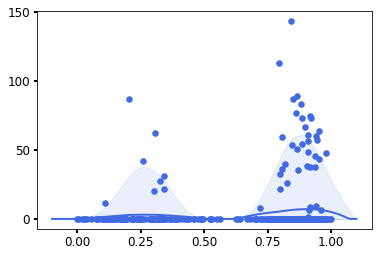

ENSMUSG00000059173


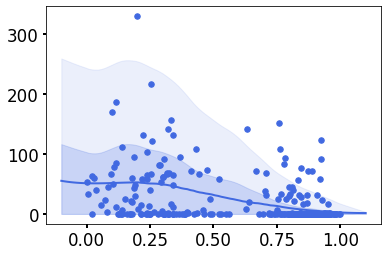

100%|██████████| 2/2 [00:06<00:00,  3.32s/it]

The results for Negative_binomial likelihood:


,Dynamic_model_log_likelihood,Dynamic_time
ENSMUSG00000015879,-386.501823,0:00:02.579209
ENSMUSG00000059173,-818.595650,0:00:04.049591


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


ENSMUSG00000015879


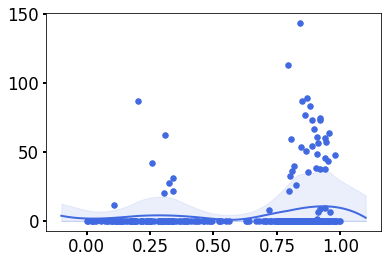

ENSMUSG00000059173


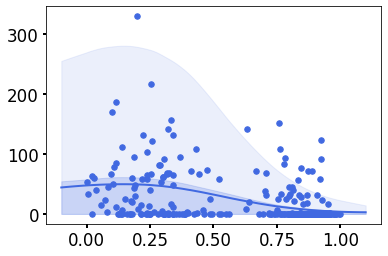

100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

The results for Gaussian likelihood:


,Dynamic_model_log_likelihood,Dynamic_time
ENSMUSG00000015879,-552.822172,0:00:00.710230
ENSMUSG00000059173,-621.691997,0:00:00.410937


100%|██████████| 2/2 [00:00<00:00, 30.47it/s]

ENSMUSG00000015879


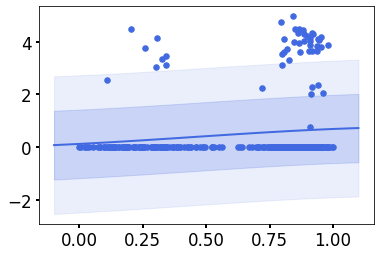

ENSMUSG00000059173


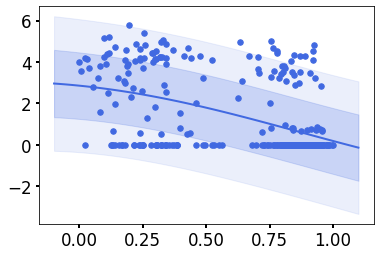

In [7]:
gp_counts = Fit_GPcounts(X,Y.loc[gene_name]) 
likelihoods = ['Zero_inflated_negative_binomial','Negative_binomial','Gaussian']
test = 'Infer_trajectory' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None]

for likelihood in likelihoods:
    results = gp_counts.Infer_trajectory(likelihood)
    print('The results for '+likelihood+' likelihood:')
    display(results)
    indexes = results.index.values.tolist() # list of genes to be plotted 
    params = gp_counts.load_models(indexes,test,xtest,likelihood)
    for i in range(len(indexes)):
        fig = plt.figure()
        print(indexes[i])
        model_index = 1
        for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
            plot()
            model_index = model_index + 1


#### Fit GPcounts using sparse GP

100%|██████████| 2/2 [00:24<00:00, 12.21s/it]

The results for Zero_inflated_negative_binomial likelihood:


,Dynamic_model_log_likelihood,Dynamic_time
ENSMUSG00000015879,-380.656228,0:00:19.303121
ENSMUSG00000059173,-787.675794,0:00:05.114818


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


ENSMUSG00000015879


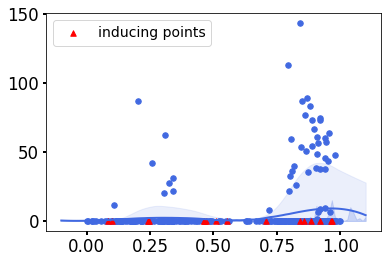

ENSMUSG00000059173


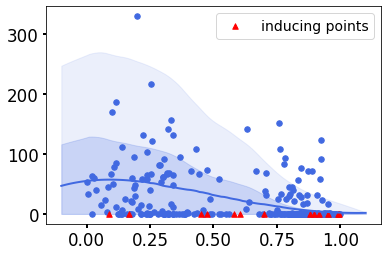

100%|██████████| 2/2 [00:04<00:00,  2.48s/it]

The results for Negative_binomial likelihood:


,Dynamic_model_log_likelihood,Dynamic_time
ENSMUSG00000015879,-386.520350,0:00:03.393701
ENSMUSG00000059173,-818.595711,0:00:01.555386


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


ENSMUSG00000015879


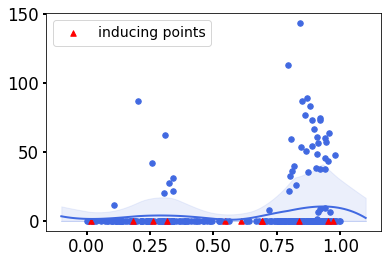

ENSMUSG00000059173


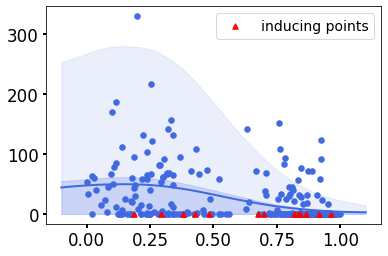

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

The results for Gaussian likelihood:


,Dynamic_model_log_likelihood,Dynamic_time
ENSMUSG00000015879,-552.822210,0:00:00.868273
ENSMUSG00000059173,-621.692019,0:00:00.448930


100%|██████████| 2/2 [00:00<00:00, 30.59it/s]


ENSMUSG00000015879


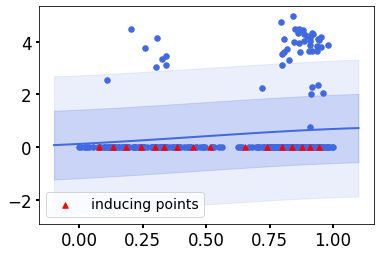

ENSMUSG00000059173


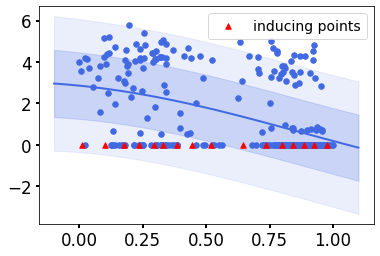

In [8]:
sparse = True
gp_counts = Fit_GPcounts(X,Y.loc[gene_name],sparse = sparse) 
likelihoods = ['Zero_inflated_negative_binomial','Negative_binomial','Gaussian']
test = 'Infer_trajectory' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None]

for likelihood in likelihoods:
    results = gp_counts.Infer_trajectory(likelihood)
    print('The results for '+likelihood+' likelihood:')
    display(results)
    indexes = results.index.values.tolist() # list of genes to be plotted 
    params = gp_counts.load_models(indexes,test,xtest,likelihood)
    for i in range(len(indexes)):
        fig = plt.figure()
        print(indexes[i])
        model_index = 1
        for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
            plot(sparse)
            model_index = model_index + 1



100%|██████████| 2/2 [00:35<00:00, 17.67s/it]

The results for Zero_inflated_negative_binomial likelihood:


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,Dynamic_time,Constant_time
ENSMUSG00000015879,-380.656228,-357.247552,0.000000,0:00:04.125089,0:00:04.125089
ENSMUSG00000059173,-787.675794,-816.813188,29.137394,0:00:04.358741,0:00:04.358741



100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


ENSMUSG00000015879


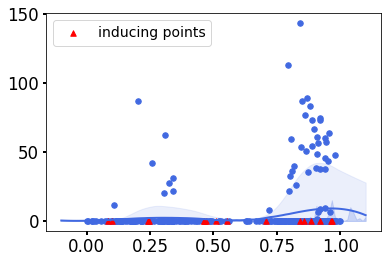

2


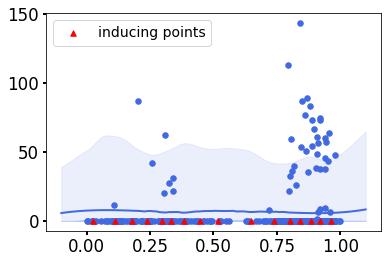

3
ENSMUSG00000059173


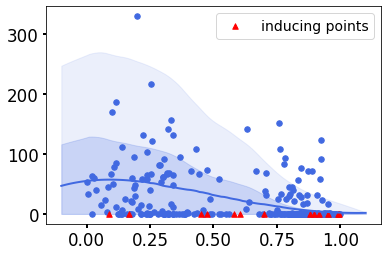

2


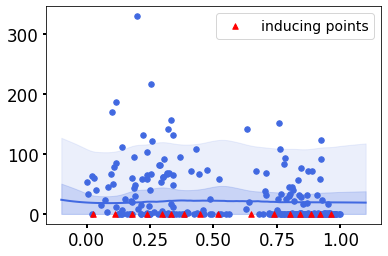


  0%|          | 0/2 [00:00<?, ?it/s]

3



100%|██████████| 2/2 [00:07<00:00,  3.60s/it]

The results for Negative_binomial likelihood:


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,Dynamic_time,Constant_time
ENSMUSG00000015879,-386.520350,-387.005185,0.484835,0:00:03.110063,0:00:03.110063
ENSMUSG00000059173,-818.595711,-829.576449,10.980738,0:00:01.747517,0:00:01.747517



100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


ENSMUSG00000015879


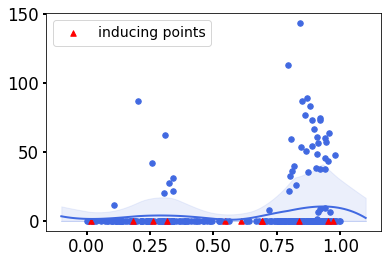

2


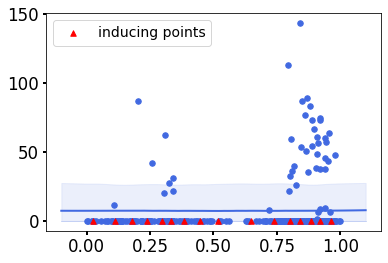

3
ENSMUSG00000059173


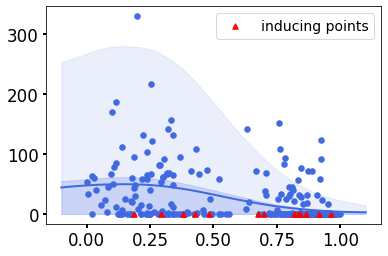

2


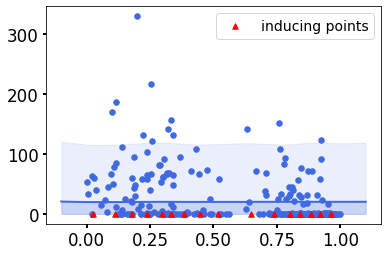


  0%|          | 0/2 [00:00<?, ?it/s]

3



100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

The results for Gaussian likelihood:


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,Dynamic_time,Constant_time
ENSMUSG00000015879,-552.822210,-555.383528,2.561318,0:00:00.451642,0:00:00.451642
ENSMUSG00000059173,-621.692019,-662.542201,40.850182,0:00:00.444802,0:00:00.444802



100%|██████████| 2/2 [00:00<00:00, 21.41it/s]


ENSMUSG00000015879


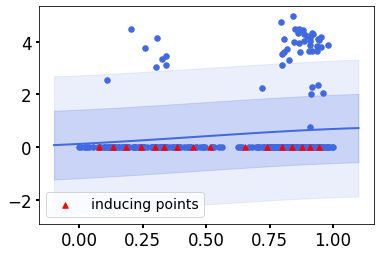

2


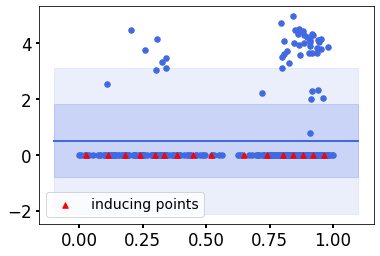

3
ENSMUSG00000059173


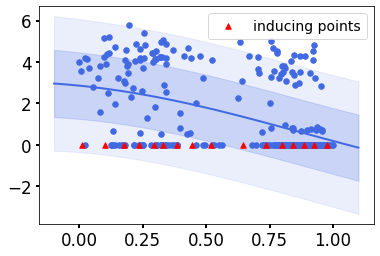

2


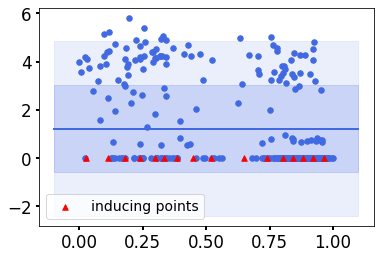

3


In [11]:
sparse = True
gp_counts = Fit_GPcounts(X,Y.loc[gene_name],sparse = sparse) 
likelihoods = ['Zero_inflated_negative_binomial','Negative_binomial','Gaussian']
test = 'One_sample_test' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None]

for likelihood in likelihoods:
    results = gp_counts.One_sample_test(likelihood)
    print('The results for '+likelihood+' likelihood:')
    display(results)
    indexes = results.index.values.tolist() # list of genes to be plotted 
    params = gp_counts.load_models(indexes,test,xtest,likelihood)
    for i in range(len(indexes)):
        fig = plt.figure()
        print(indexes[i])
        model_index = 1
        for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
            plot(sparse)
            model_index = model_index + 1